In [58]:
!pip install -qq xgboost
!pip install -qq xgbimputer
!pip install -qq imbalanced-learn
!pip install -qq optuna

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from tabulate import tabulate
from xgbimputer import XGBImputer
import optuna
import os
import pickle

# Data Loading

In [60]:
df = pd.read_csv('/work/Credit_Card_Churn_Intern_BCC_2024/Dataset/BankChurners.csv')
df.drop(columns=['CLIENTNUM','Avg_Open_To_Buy','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

In [61]:
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
df_copy = df.copy()

# Baseline Model

In [62]:
df = pd.get_dummies(df, columns=['Gender', 'Marital_Status'], drop_first=True)

df['Education_Level'] = df['Education_Level'].map({'Uneducated': 0, 'High School': 1, 'Unknown': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate':5, 'Doctorate': 6})
df['Income_Category'] = df['Income_Category'].map({'Less than $40K': 0, '$40K - $60K': 1, 'Unknown': 2,'$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5})
df['Card_Category'] = df['Card_Category'].map({'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3})

Because the 'Unknown' category consistently have mid size population, I put them in the middle as it could go either way.

In [63]:
X = df.drop(columns='Attrition_Flag')
y = df['Attrition_Flag']

In [64]:
numeric_columns = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio"
]

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_scaled = numeric_pipeline.fit_transform(X_train[numeric_columns])

# Transform the testing data
X_test_scaled = numeric_pipeline.transform(X_test[numeric_columns])

# Replace the original numeric columns in X_train and X_test with the scaled ones
X_train[numeric_columns] = X_train_scaled
X_test[numeric_columns] = X_test_scaled

In [65]:
# X_scaled = X.copy()

In [66]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(kernel='rbf', C=1, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=100),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
}

In [67]:
# Define business value scores
TP_value = 200
TN_value = 0
FP_value = -50
FN_value = 100


def train_result(X_train, X_test, y_train, y_test):
    results = []
    trained_models = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Calculate TP, TN, FP, and FN
        tn, fp, fn, tp = cm.ravel()

        # Calculate precision and recall
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1_score = fbeta_score(y_test, y_pred, beta=1)
        f2_score = fbeta_score(y_test, y_pred, beta=2)

        # Calculate business value score
        business_value_score = (tp * TP_value) + (tn * TN_value) + (fp * FP_value) + (fn * FN_value)

        # Format results and append to the list
        results.append([name, precision, recall, f1_score, f2_score, tp, tn, fp, fn, business_value_score])
        
        # Save trained models
        trained_models[name] = clf

    # Create a table using tabulate
    headers = ["Classifier", "Precision", "Recall", "F1 Score", "F2 Score", "TP", "TN", "FP", "FN", "Business Value Score"]
    table = tabulate(results, headers=headers)

    # Print the table
    print(table)
    
    # Return trained models
    return trained_models

In [68]:
train_result(X_train, X_test, y_train, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.864583  0.507645    0.639692    0.553333   166  1673    26   161                   48000
SVM                     0.876033  0.648318    0.745167    0.683871   212  1669    30   115                   52400
Logistic Regression     0.774892  0.547401    0.641577    0.581546   179  1647    52   148                   48000
Random Forest           0.921986  0.795107    0.853859    0.81761    260  1677    22    67                   57600
XGBoost                 0.904025  0.892966    0.898462    0.895156   292  1668    31    35                   60350


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

The best baseline model is XGBoost with 89.5% F2 Score and The worst is KNN with 55% F2 Score.

In [69]:
results = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    # Calculate the cross-validation scores
    f2_scores = []
    precision_scores = []
    recall_scores = []
    business_value_scores = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = numeric_pipeline.fit_transform(X_train[numeric_columns])
        # Transform the testing data
        X_test_scaled = numeric_pipeline.transform(X_test[numeric_columns])

        # Replace the original numeric columns in X_train and X_test with the scaled ones
        X_train.loc[:, numeric_columns] = X_train_scaled
        X_test.loc[:, numeric_columns] = X_test_scaled

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f2 = fbeta_score(y_test, y_pred, beta=2)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate business value score
        business_value_score = (tp * TP_value) + (tn * TN_value) + (fp * FP_value) + (fn * FN_value)

        f2_scores.append(f2)
        precision_scores.append(precision)
        recall_scores.append(recall)
        business_value_scores.append(business_value_score)

    # Calculate the mean F2 score, precision, recall, and business value score
    mean_f2_score = np.mean(f2_scores)
    mean_precision_score = np.mean(precision_scores)
    mean_recall_score = np.mean(recall_scores)
    mean_business_value_score = np.mean(business_value_scores)

    std_f2_score = np.std(f2_scores)
    std_precision_score = np.std(precision_scores)
    std_recall_score = np.std(recall_scores)
    std_business_value_score = np.std(business_value_scores)

    # Format results and append to the list
    results.append([name, "{:.3f}+-{:.3f}".format(mean_precision_score, std_precision_score), "{:.3f}+-{:.3f}".format(mean_recall_score, std_recall_score), "{:.3f}+-{:.3f}".format(mean_f2_score, std_f2_score), mean_business_value_score])


# Create a table using tabulate
headers = ["Classifier", "Mean Precision", "Mean Recall", "Mean F2 Score", "Mean Business Value Score"]
table = tabulate(results, headers=headers)

# Print the table
print(table)

Classifier           Mean Precision    Mean Recall    Mean F2 Score      Mean Business Value Score
-------------------  ----------------  -------------  ---------------  ---------------------------
KNN                  0.836+-0.026      0.521+-0.009   0.563+-0.008                           47810
SVM                  0.869+-0.012      0.673+-0.020   0.704+-0.017                           52770
Logistic Regression  0.764+-0.017      0.584+-0.030   0.613+-0.027                           48610
Random Forest        0.934+-0.018      0.813+-0.018   0.835+-0.016                           58070
XGBoost              0.934+-0.019      0.901+-0.013   0.908+-0.013                           60820


I evaluate how good the model with unseen data and surprisingly it got a better result with 90% F2 Score using XGBoost.

# XGBoost Imputed

Based on EDA we know that 'Unknown' Category has their own pattern so we can't simply impute them with simple imputer. And, are they actually other value that's obfuscated or their own category.

I use XGBoost Imputer because it can handle categorical data meanwhile KNN Imputer doesn't work with one hot encoded data as it will only consider one column at a time.

In [70]:
df_copy.replace('Unknown', np.nan, inplace=True)
df_copy = pd.get_dummies(df_copy, columns=['Gender'], drop_first=True)
df_copy['Card_Category'] = df_copy['Card_Category'].map({'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3})

In [71]:
df_copy_missing_data = pd.DataFrame(df_copy.isna().sum().loc[df_copy.isna().sum() > 0], columns=['missing_data_count'])
df_copy_missing_data['missing_data_type'] = df_copy.dtypes
df_copy_missing_data['missing_data_percentage'] = df_copy_missing_data['missing_data_count'] / len(df_copy)
df_copy_missing_data = df_copy_missing_data.sort_values(by='missing_data_percentage', ascending=False)
df_copy_missing_data

,missing_data_count,missing_data_type,missing_data_percentage
Education_Level,1519,object,0.149995
Income_Category,1112,object,0.109805
Marital_Status,749,object,0.073961


In [72]:
imputer = XGBImputer(categorical_features_index=[3,4,5], replace_categorical_values_back=True)
X = imputer.fit_transform(df_copy)

/root/venv/lib/python3.9/site-packages/xgbimputer/xgbimputer.py:148: RuntimeWarning: invalid value encountered in double_scalars
  gamma_inferred_numerical_features_new = np.sum((Ximp[:,self.inferred_numerical_features_index] - Ximp_old[:,self.inferred_numerical_features_index])**2)/np.sum((Ximp[:, self.inferred_numerical_features_index]) ** 2)
XGBImputer - Epoch: 1 | Categorical gamma: inf/7. | Numerical gamma: inf/nan
/root/venv/lib/python3.9/site-packages/xgbimputer/xgbimputer.py:148: RuntimeWarning: invalid value encountered in double_scalars
  gamma_inferred_numerical_features_new = np.sum((Ximp[:,self.inferred_numerical_features_index] - Ximp_old[:,self.inferred_numerical_features_index])**2)/np.sum((Ximp[:, self.inferred_numerical_features_index]) ** 2)
XGBImputer - Epoch: 2 | Categorical gamma: 7./0. | Numerical gamma: nan/nan
XGBImputer - Epoch: 3 | Categorical gamma: 0./0. | Numerical gamma: nan/nan
/root/venv/lib/python3.9/site-packages/xgbimputer/xgbimputer.py:148: RuntimeW

In [73]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,45.0,3.0,High School,Married,$60K - $80K,0.0,39.0,5.0,1.0,3.0,12691.0,777.0,1.335,1144.0,42.0,1.625,0.061,1.0
1,0.0,49.0,5.0,Graduate,Single,Less than $40K,0.0,44.0,6.0,1.0,2.0,8256.0,864.0,1.541,1291.0,33.0,3.714,0.105,0.0
2,0.0,51.0,3.0,Graduate,Married,$80K - $120K,0.0,36.0,4.0,1.0,0.0,3418.0,0.0,2.594,1887.0,20.0,2.333,0.0,1.0
3,0.0,40.0,4.0,High School,Married,Less than $40K,0.0,34.0,3.0,4.0,1.0,3313.0,2517.0,1.405,1171.0,20.0,2.333,0.76,0.0
4,0.0,40.0,3.0,Uneducated,Married,$60K - $80K,0.0,21.0,5.0,1.0,0.0,4716.0,0.0,2.175,816.0,28.0,2.5,0.0,1.0


In [74]:
X[3].unique()

array(['High School', 'Graduate', 'Uneducated', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

In [75]:
X = pd.get_dummies(X, columns=[4], drop_first=True)
X[3] = X[3].map({'Uneducated': 0, 'High School': 1, 'College': 2, 'Graduate': 3, 'Post-Graduate':4, 'Doctorate': 5})
X[5] = X[5].map({'Less than $40K': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K': 3, '$120K +': 4})

Manually order labelling the category data.

In [76]:
y = X[0]
X = X.drop(columns=0)

In [77]:
X = X.select_dtypes('object').astype(float)

In [78]:
y = y.astype(float)

In [79]:
X.head()

,1,2,6,7,8,9,10,11,12,13,14,15,16,17,18
0,45.0,3.0,0.0,39.0,5.0,1.0,3.0,12691.0,777.0,1.335,1144.0,42.0,1.625,0.061,1.0
1,49.0,5.0,0.0,44.0,6.0,1.0,2.0,8256.0,864.0,1.541,1291.0,33.0,3.714,0.105,0.0
2,51.0,3.0,0.0,36.0,4.0,1.0,0.0,3418.0,0.0,2.594,1887.0,20.0,2.333,0.000,1.0
3,40.0,4.0,0.0,34.0,3.0,4.0,1.0,3313.0,2517.0,1.405,1171.0,20.0,2.333,0.760,0.0
4,40.0,3.0,0.0,21.0,5.0,1.0,0.0,4716.0,0.0,2.175,816.0,28.0,2.500,0.000,1.0


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_scaled = numeric_pipeline.fit_transform(X_train[[1,2,6,7,8,9,10,11,12,13,14,15,16,17]])

# Transform the testing data
X_test_scaled = numeric_pipeline.transform(X_test[[1,2,6,7,8,9,10,11,12,13,14,15,16,17]])

# Replace the original numeric columns in X_train and X_test with the scaled ones
X_train[[1,2,6,7,8,9,10,11,12,13,14,15,16,17]] = X_train_scaled
X_test[[1,2,6,7,8,9,10,11,12,13,14,15,16,17]] = X_test_scaled

In [81]:
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(kernel='rbf', C=1, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=100),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
}

In [82]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 10127 entries, 0 to 10126
Series name: 0
Non-Null Count  Dtype  
--------------  -----  
10127 non-null  float64
dtypes: float64(1)
memory usage: 79.2 KB


In [83]:
# results = []

# for name, clf in classifiers.items():
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     cm = confusion_matrix(y_test, y_pred)

#     # Calculate TP, TN, FP, and FN
#     tn, fp, fn, tp = cm.ravel()

#     # Calculate precision and recall
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1_score = fbeta_score(y_test, y_pred, beta=1)
#     f2_score = fbeta_score(y_test, y_pred, beta=2)

#     # Format results and append to the list
#     results.append([name, precision, recall, f1_score, f2_score, tp, tn, fp, fn])

# # Create a table using tabulate
# headers = ["Classifier", "Precision", "Recall", "F1 Score", "F2 Score", "TP", "TN", "FP", "FN"]
# table = tabulate(results, headers=headers)

# # Print the table
# print(table)

train_result(X_train, X_test, y_train, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.823789  0.571865    0.67509     0.609121   187  1659    40   140                   49400
SVM                     0.87747   0.678899    0.765517    0.711083   222  1668    31   105                   53350
Logistic Regression     0.777778  0.535168    0.634058    0.570776   175  1649    50   152                   47700
Random Forest           0.932384  0.801223    0.861842    0.824418   262  1680    19    65                   57950
XGBoost                 0.901274  0.865443    0.882995    0.87238    283  1668    31    44                   59450


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

The result is both surprising and not surprising, the imputed data perform worse than the baseline. This might be caused by overfitting.

# Sampling

Addressing the data imbalance through sampling, I have formulated a few hypotheses. Undersampling is anticipated to yield higher recall but lower precision, given the reduced data for non-churn customers. On the other hand, oversampling is expected to have a minimal impact on precision, with a potential increase in recall, but there is a risk of overfitting.

A well-balanced approach involves employing oversampled data for general model training. However, when the specific goal is to predict churn customers, a focused strategy would be to use an undersampled model."

In [84]:
X = df.drop(columns='Attrition_Flag')
y = df['Attrition_Flag']

In [85]:
numeric_columns = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio"
]

# Standardize numeric columns
scaler = StandardScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

In [86]:
# X_scaled = X.copy()

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_scaled = numeric_pipeline.fit_transform(X_train[numeric_columns])

# Transform the testing data
X_test_scaled = numeric_pipeline.transform(X_test[numeric_columns])

# Replace the original numeric columns in X_train and X_test with the scaled ones
X_train[numeric_columns] = X_train_scaled
X_test[numeric_columns] = X_test_scaled

oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [88]:
train_result(X_train_undersampled, X_test, y_train_undersampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.508197  0.853211    0.636986    0.751212   279  1429   270    48                   47100
SVM                     0.598765  0.889908    0.715867    0.811037   291  1504   195    36                   52050
Logistic Regression     0.513109  0.83792     0.636469    0.743757   274  1439   260    53                   47100
Random Forest           0.753027  0.95107     0.840541    0.903544   311  1597   102    16                   58700
XGBoost                 0.7825    0.957187    0.861073    0.916276   313  1612    87    14                   59650


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

In [89]:
train_result(X_train_oversampled, X_test, y_train_oversampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.528487  0.82263     0.643541    0.740231   269  1459   240    58                   47600
SVM                     0.647577  0.899083    0.752881    0.834279   294  1539   160    33                   54100
Logistic Regression     0.526012  0.834862    0.64539     0.747126   273  1453   246    54                   47700
Random Forest           0.9       0.853211    0.875981    0.862176   279  1668    31    48                   59050
XGBoost                 0.880117  0.920489    0.899851    0.912121   301  1658    41    26                   60750


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

The hypothesis has been validated through the model evaluations. The undersampled XGBoost model exhibits a notable 5% increase in recall at the cost of a 22% decrease in precision, representing a trade-off. Conversely, the oversampled XGBoost model strikes a more balanced approach, with a 2% decrease in precision and a 2% increase in recall. Notably, the undersampled model outperforms the oversampled one in terms of F2 score, with 91.6% compared to 91.2%. This emphasizes the significance of F2 score, which prioritizes minimizing False Negatives.

In [90]:
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

tomek_links = TomekLinks()
X_train_undersampled, y_train_undersampled = tomek_links.fit_resample(X_train, y_train)

In [91]:
train_result(X_train_undersampled, X_test, y_train_undersampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.846154  0.538226    0.657944    0.580475   176  1667    32   151                   48700
SVM                     0.862205  0.669725    0.753873    0.701024   219  1664    35   108                   52850
Logistic Regression     0.765182  0.577982    0.658537    0.607717   189  1641    58   138                   48700
Random Forest           0.90378   0.804281    0.851133    0.822389   263  1671    28    64                   57600
XGBoost                 0.878419  0.883792    0.881098    0.882712   289  1659    40    38                   59600


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

In [92]:
train_result(X_train_oversampled, X_test, y_train_oversampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.537549  0.831804    0.653061    0.749724   272  1465   234    55                   48200
SVM                     0.689655  0.856269    0.763984    0.816803   280  1573   126    47                   54400
Logistic Regression     0.543158  0.788991    0.643392    0.7235     258  1482   217    69                   47650
Random Forest           0.874618  0.874618    0.874618    0.874618   286  1658    41    41                   59250
XGBoost                 0.881818  0.889908    0.885845    0.888278   291  1660    39    36                   59850


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

# Feature Selection

In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              10127 non-null  float64
 1   Dependent_count           10127 non-null  float64
 2   Education_Level           10127 non-null  int64  
 3   Income_Category           10127 non-null  int64  
 4   Card_Category             10127 non-null  int64  
 5   Months_on_book            10127 non-null  float64
 6   Total_Relationship_Count  10127 non-null  float64
 7   Months_Inactive_12_mon    10127 non-null  float64
 8   Contacts_Count_12_mon     10127 non-null  float64
 9   Credit_Limit              10127 non-null  float64
 10  Total_Revolving_Bal       10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 12  Total_Trans_Amt           10127 non-null  float64
 13  Total_Trans_Ct            10127 non-null  float64
 14  Total_

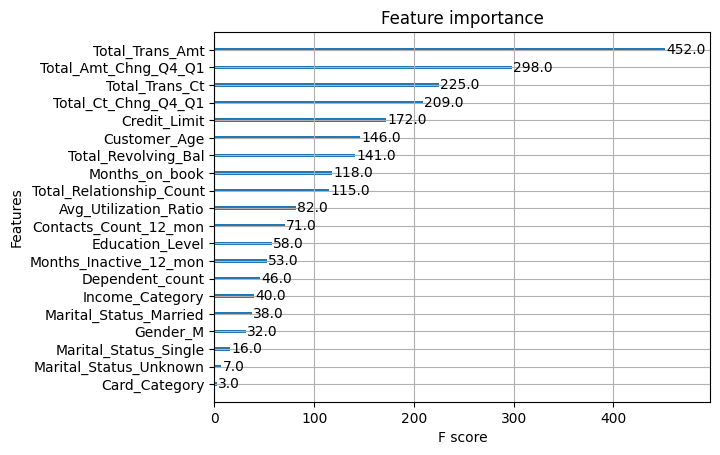

In [94]:
plot_importance(xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42).fit(X_train, y_train))
plt.show()

I use 15 most important features according to XGBoost 

In [95]:
selected_features = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Avg_Utilization_Ratio",
    'Income_Category',
    'Education_Level'
]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_scaled = numeric_pipeline.fit_transform(X_train[numeric_columns])

# Transform the testing data
X_test_scaled = numeric_pipeline.transform(X_test[numeric_columns])

# Replace the original numeric columns in X_train and X_test with the scaled ones
X_train[numeric_columns] = X_train_scaled
X_test[numeric_columns] = X_test_scaled

In [97]:
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

undersampler = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

In [98]:
train_result(X_train_undersampled, X_test, y_train_undersampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.501859  0.825688    0.624277    0.731311   270  1431   268    57                   46300
SVM                     0.588595  0.883792    0.706601    0.803224   289  1497   202    38                   51500
Logistic Regression     0.517045  0.834862    0.638596    0.743464   273  1444   255    54                   47250
Random Forest           0.776382  0.944954    0.852414    0.905627   309  1610    89    18                   59150
XGBoost                 0.758373  0.969419    0.851007    0.918308   317  1598   101    10                   59350


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

In [99]:
train_result(X_train_oversampled, X_test, y_train_oversampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.525794  0.810398    0.637786    0.731236   265  1460   239    62                   47250
SVM                     0.657778  0.905199    0.761905    0.841866   296  1545   154    31                   54600
Logistic Regression     0.511236  0.834862    0.634146    0.741042   273  1438   261    54                   46950
Random Forest           0.892508  0.83792     0.864353    0.848297   274  1666    33    53                   58450
XGBoost                 0.878338  0.905199    0.891566    0.899696   296  1658    41    31                   60250


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

In [100]:
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

tomek_links = TomekLinks()
X_train_undersampled, y_train_undersampled = tomek_links.fit_resample(X_train, y_train)

In [101]:
train_result(X_train_undersampled, X_test, y_train_undersampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.843434  0.510703    0.63619     0.554449   167  1668    31   160                   47850
SVM                     0.863454  0.657492    0.746528    0.69043    215  1665    34   112                   52500
Logistic Regression     0.765957  0.550459    0.640569    0.583279   180  1644    55   147                   47950
Random Forest           0.916955  0.810398    0.86039     0.829681   265  1675    24    62                   58000
XGBoost                 0.903427  0.88685     0.895062    0.890117   290  1668    31    37                   60150


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

In [102]:
train_result(X_train_oversampled, X_test, y_train_oversampled, y_test)

Classifier             Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
-------------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
KNN                     0.532417  0.828746    0.648325    0.745735   271  1461   238    56                   47900
SVM                     0.665105  0.868502    0.753316    0.818444   284  1556   143    43                   53950
Logistic Regression     0.525591  0.816514    0.639521    0.735132   267  1458   241    60                   47350
Random Forest           0.870769  0.865443    0.868098    0.866503   283  1657    42    44                   58900
XGBoost                 0.891975  0.883792    0.887865    0.885417   289  1664    35    38                   59850


{'KNN': KNeighborsClassifier(n_neighbors=7),
 'SVM': SVC(C=1, random_state=42),
 'Logistic Regression': LogisticRegression(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

After applying feature selection, the undersampled XGBoost model demonstrates enhanced focus, achieving 75% precision, 95% recall, and an impressive 91.8% F2 score. In contrast, the oversampled model experiences a decline in performance, with an overall 1% decrease across all scores compared to its state before feature selection.

# Hyperparameter tuning

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_scaled = numeric_pipeline.fit_transform(X_train[numeric_columns])

# Transform the testing data
X_test_scaled = numeric_pipeline.transform(X_test[numeric_columns])

# Replace the original numeric columns in X_train and X_test with the scaled ones
X_train[numeric_columns] = X_train_scaled
X_test[numeric_columns] = X_test_scaled

oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

In [106]:
def calculate_business_value(conf_matrix):
    TP_value = 200
    TN_value = 0
    FP_value = -50
    FN_value = 100

    TN, FP, FN, TP = conf_matrix.ravel()

    return (TP * TP_value) + (TN * TN_value) + (FP * FP_value) + (FN * FN_value)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Define k-fold cross-validation

    values = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = numeric_pipeline.fit_transform(X_train[numeric_columns])
        # Transform the testing data
        X_test_scaled = numeric_pipeline.transform(X_test[numeric_columns])

        # Replace the original numeric columns in X_train and X_test with the scaled ones
        X_train.loc[:, numeric_columns] = X_train_scaled
        X_test.loc[:, numeric_columns] = X_test_scaled

        oversampler = RandomOverSampler(random_state=42)
        X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

        model = xgb.XGBClassifier(**params, random_state=42)
        model.fit(X_train_oversampled, y_train_oversampled)
        y_pred = model.predict(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        value = calculate_business_value(conf_matrix)
        values.append(value)

    avg_value = sum(values) / len(values)
    return avg_value

In [109]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=5000)
trial = study.best_trial
best_params = trial.params

[I 2024-03-15 12:51:18,067] A new study created in memory with name: no-name-a20d6574-2e67-449c-a1ed-733b60c5bac3
[I 2024-03-15 12:51:19,197] Trial 0 finished with value: 61100.0 and parameters: {'max_depth': 5, 'eta': 0.2536999076681772, 'gamma': 0.007177141927992002, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 61100.0.
[I 2024-03-15 12:51:20,320] Trial 1 finished with value: 55390.0 and parameters: {'max_depth': 4, 'eta': 0.012184186502221764, 'gamma': 0.08499808989182997, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 61100.0.
[I 2024-03-15 12:51:21,224] Trial 2 finished with value: 60470.0 and parameters: {'max_depth': 3, 'eta': 0.2708160864249968, 'gamma': 0.04566054873446119, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 61100.0.
[I 2024-03-15 12:51:22,203] Trial 3 finished with value: 57570.0 and parameters: {'ma

In [ ]:
print(best_params)

{'max_depth': 5, 'eta': 0.26592844752396194, 'gamma': 0.0008146823932646719, 'subsample': 0.7743426174829405, 'colsample_bytree': 0.9618170551771399}


In [104]:
classifiers = {
    "XGBoost": xgb.XGBClassifier(**best_params, random_state=42),
}

In [105]:
xgb_model = train_result(X_train_oversampled, X_test, y_train_oversampled, y_test)

save_dir = "/work/Credit_Card_Churn_Intern_BCC_2024/Model/"
model_file_path = os.path.join(save_dir, 'xgb_model.pkl')
with open(model_file_path, 'wb') as file:
    pickle.dump(xgb_model, file)

Classifier      Precision    Recall    F1 Score    F2 Score    TP    TN    FP    FN    Business Value Score
------------  -----------  --------  ----------  ----------  ----  ----  ----  ----  ----------------------
XGBoost          0.887906  0.920489    0.903904    0.913783   301  1661    38    26                   60900


In [ ]:
results = []
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    # Calculate the cross-validation scores and mean TP, TN, FP, FN
    f2_scores = []
    precision_scores = []
    recall_scores = []
    business_value_scores = []
    tp_values = []
    tn_values = []
    fp_values = []
    fn_values = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = numeric_pipeline.fit_transform(X_train[numeric_columns])
        # Transform the testing data
        X_test_scaled = numeric_pipeline.transform(X_test[numeric_columns])

        # Replace the original numeric columns in X_train and X_test with the scaled ones
        X_train.loc[:, numeric_columns] = X_train_scaled
        X_test.loc[:, numeric_columns] = X_test_scaled

        oversampler = RandomOverSampler(random_state=42)
        X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

        clf.fit(X_train_oversampled, y_train_oversampled)
        y_pred = clf.predict(X_test)
        f2 = fbeta_score(y_test, y_pred, beta=2)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate business value score
        business_value_score = (tp * TP_value) + (tn * TN_value) + (fp * FP_value) + (fn * FN_value)

        f2_scores.append(f2)
        precision_scores.append(precision)
        recall_scores.append(recall)
        business_value_scores.append(business_value_score)
        
        # Append TP, TN, FP, FN values
        tp_values.append(tp)
        tn_values.append(tn)
        fp_values.append(fp)
        fn_values.append(fn)

    # Calculate the mean values
    mean_f2_score = np.mean(f2_scores)
    mean_precision_score = np.mean(precision_scores)
    mean_recall_score = np.mean(recall_scores)
    mean_business_value_score = np.mean(business_value_scores)
    mean_tp = np.mean(tp_values)
    mean_tn = np.mean(tn_values)
    mean_fp = np.mean(fp_values)
    mean_fn = np.mean(fn_values)

    # Calculate the standard deviations
    std_tp = np.std(tp_values)
    std_tn = np.std(tn_values)
    std_fp = np.std(fp_values)
    std_fn = np.std(fn_values)

    # Format results and append to the list
    results.append([name, 
                    "{:.3f}+-{:.3f}".format(mean_precision_score, std_precision_score), 
                    "{:.3f}+-{:.3f}".format(mean_recall_score, std_recall_score), 
                    "{:.3f}+-{:.3f}".format(mean_f2_score, std_f2_score), 
                    "{:.1f}+-{:.1f}".format(mean_tp, std_tp), 
                    "{:.1f}+-{:.1f}".format(mean_tn, std_tn), 
                    "{:.1f}+-{:.1f}".format(mean_fp, std_fp), 
                    "{:.1f}+-{:.1f}".format(mean_fn, std_fn), 
                    "{:.3f}+-{:.3f}".format(mean_business_value_score, std_business_value_score)])

# Create a table using tabulate
headers = ["Classifier", "Mean Precision", "Mean Recall", "Mean F2 Score", "Mean TP", "Mean TN", "Mean FP", "Mean FN", "Mean Business Value Score"]
table = tabulate(results, headers=headers)

# Print the table
print(table)

Classifier    Mean Precision    Mean Recall    Mean F2 Score    Mean TP     Mean TN       Mean FP    Mean FN    Mean Business Value Score
------------  ----------------  -------------  ---------------  ----------  ------------  ---------  ---------  ---------------------------
XGBoost       0.910+-0.017      0.932+-0.007   0.928+-0.008     303.4+-7.2  1670.0+-11.0  30.0+-6.1  22.0+-2.7  61380.000+-1579.114


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6ad58bc5-59dd-429f-97b6-3cedb5b4fcfc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>